## Welcome to the Digital Frontier 

<a href="https://wfseaton.github.io/TheDigitalFrontier/">Home Page</a> - 
<a href="https://wfseaton.github.io/TheDigitalFrontier/data_preparation.html">Data Preparation</a> - 
<a href="https://wfseaton.github.io/TheDigitalFrontier/data_exploration.html">Data Exploration</a> - 
<a href="https://wfseaton.github.io/TheDigitalFrontier/dimensionality_reduction.html"><b>Dimensionality Reduction</b></a> - 
<a href="https://wfseaton.github.io/TheDigitalFrontier/clustering_techniques.html">Clustering Techniques</a> - 
<a href="https://wfseaton.github.io/TheDigitalFrontier/playlist_generation.html">Playlist Generation</a> - 
<a href="https://wfseaton.github.io/TheDigitalFrontier/conclusion.html">Conclusion</a> - 
<a href="https://wfseaton.github.io/TheDigitalFrontier/authors_gift.html">Authors' Gift</a>

-------------------------------------------------------------------------------------------------------------------

# Leveraging Feature Importance through Dimensionality Reduction

In [145]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix, save_npz
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
assert tf.__version__ == '2.0.0'

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## 1. Load and prepare songs data
Read in the prepared dataset of songs across 200,000 playlists, with song metadata added via the Spotify API. This is the master table of song data, which we can use later for looking up information on songs, for instance when generating playlists. For the purposes of modelling, we need to convert it into a dataset of numerical predictors, do some feature engineering, and some cleaning.

In [17]:
# Load master song table with added metadata
master = pd.read_pickle('../data/master200.pkl')
print('Dimensions:', master.shape)
display(master.head())

Dimensions: (999950, 25)


,artist_name,artist_uri,track_name,album_uri,duration_ms,album_name,count,track_uri,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,artist_genres,artist_popularity,album_genres,album_popularity,album_release_date
song_id,,,,,,,,,,,,,,,,,,,,,
0,Sidney Bechet's Blue Note Jazzmen,spotify:artist:2XouUSO0EAJ9gMMoHiXqMt,Muskrat Ramble,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,220293,Jazz Classics,1,spotify:track:0002yNGLtYSYtc0X6ZnFvp,0.455,0.623,...,0.903,0.6340,0.951,182.345,4,[],18,[],37,1993-01-01
159583,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blue Horizon,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,264933,Jazz Classics,5,spotify:track:1EWPMNHfdVNJwBpG9BcxXB,0.327,0.372,...,0.835,0.1530,0.380,66.036,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
271702,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Blame It On The Blues - Alternate Take,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,175893,Jazz Classics,1,spotify:track:26N4Y48EjprAtvlY6yWZTA,0.574,0.606,...,0.948,0.3490,0.965,101.361,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
445190,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Summertime,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,251906,Jazz Classics,16,spotify:track:3RlJx8xwZEyToSuGrygilr,0.608,0.138,...,0.908,0.0853,0.318,83.124,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01
626275,Sidney Bechet,spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk,Dear Old Southland,spotify:album:04hQBJ7YSuNnZ0nbuXNYbY,243693,Jazz Classics,1,spotify:track:4qwAa1rOm8iaegHzoM1b31,0.400,0.320,...,0.842,0.1950,0.613,86.186,4,"['bebop', 'big band', 'cool jazz', 'dixieland'...",52,[],37,1993-01-01


There are a handful of missing values in the dataset. It's only a couple of observations, so we drop those as our models and analyses will fail with NAs present.

In [18]:
old = master.shape
master.dropna(axis = 0, inplace = True)
print('Removed', old[0] - master.shape[0], 'observations')

Removed 9 observations


Convert `album_release_year` to a continuous number of the release year. The day of month or month itself of the release date is likely much less important. Should ideally treat as categorical, but this would give a *lot* of levels and not unreasonble to treat year as ordinal. 

In [20]:
master['album_release_year'] = np.array(
    [reldate[0:4] for reldate in master['album_release_date']], dtype = 'int')
master.drop(['album_release_date'], 1, inplace = True)

print('Artists missing genres: {}%'.format(
    round(100*np.sum(master.artist_genres == '[]')/master.shape[0], 2)))

Artists missing genres: 17.6%


We can simply drop a few predictors, as they either are very sparse or contain no useful information:
- `album_genres` is always empty. Either an old field in the API that is no longer used, or data is kept secret by Spotify,. Either way it is useless to us.
- `track_uri` is the url to the track. This is unique to each song and cannot meaningfully be treated as a numerical predictor. It is saved in the original songs data frame for reference if we need it later.
- `album_uri` for the same reason.
- `artist_uri` for the same reason.
- `track_name` is textual and hard to do anything useful with unless we apply some textual data analysis or NLP, but that's out of scope for this project.
- `artist_genres` is missing quite a few values, and varies greatly in terms of specificity and the number of genres assigned to an artist. The inconsistency would make it challenging to create useful song-level features from it, so drop that too.

In [21]:
master.drop(labels = ['album_genres', 'track_uri', 'album_uri', 'artist_uri', 
                      'track_name', 'artist_genres'], axis = 1, inplace = True)

The remaining features of type `object` are `artist_name` and `album_name`. Again we might consider textual data analysis, but they are arguably best treated as categorical predictors, under the hypothesis that songs in the same album and/or by the same artist(s) likely fit well together.

There are however over 145,000 different artists and almost 300,000 albums. If we were to simply one-hot-encode these two categorical predictors that would yield 445,000 binary indicators, which is an absurdly high number of dimensions.

In light of that, it is arguably redundant to keep both the album and artist names; if a song is in the same album, most of the time it will likely also be by the same artist. By that reasoning, `artist_name` may contain the salient information about and relatedness between songs. Hence, we will keep only the `artist_name` as a categorical, as we need to reduce the dimensionality of the data.

In [22]:
print('Unique artist names:', len(set(master.artist_name.values)))
print('Unique album names:', len(set(master.album_name.values)))

Unique artist names: 145623
Unique album names: 297432


In [23]:
master.drop('album_name', axis = 1, inplace = True)

# 2. Load and prepare song-in-playlist indicators
Before we continue with preparing the songs data for modelling we will reduce dimensionality where appropriate by removing songs and playlists that are extremely rare, as we saw previously that there are very long tails of such cases.

Start by loading in the prepared list of lists that says which song IDs each playlist in the dataset consists of.

In [46]:
# Read list of lists: parent index is playlist ID, child index is song in that playlist
playlists = pd.read_pickle('../data/playlists_song_ids_200.pkl')

# Give each parent list a number, i.e. our internal playlist ID
play, song = zip(*enumerate(playlists))
print('Playlist 0 contains {} songs with IDs:\n{}'.format(len(song[0]), song[0]))

# Expand into pairs of playlist-song, i.e. 100-long playlist becomes 100 pairs
pairs = [[z[0], s] for z in zip(play, song) for s in z[1]]

# column is song ID, row is playlist ID
col, row = zip(*pairs)
assert len(row) == len(col)

Playlist 0 contains 13 songs with IDs:
[340039 125250 881533 653897  49614 356319 787744 603984 894661 461894
 776037 810569 855793]


In order to use this information of which songs are in which playlists for modelling, we wish to store it as a matrix of indicators. The row number is our internal song ID (from 0 to the number of songs), and the column number is our internal playlist ID (from 0 to the number of playlists). Each value, or cell in the matrix, is a binary indicator saying whether that song is in that playlist.

However, this would be a massive matrix of 1,000,000 rows and 200,000 columns. This is so big that the dense matrix itself would not fit in memory, let alone any calculations using it.

As such, we store this matrix as a *sparse* matrix. This is an object that doesn't store the full structure, but only records coordinate positions of non-zero values. In our case, this means only storing the indicators where a given song is in a given playlist. Using the appropriate packages we can then perform calculations on sparse matrices, greatly speeding up (or making it possible at all) computations.

In [53]:
# Create sparse matrix
mat = csr_matrix((np.ones(len(col), dtype = 'int'), (row, col)))
print('Indicators matrix dimensions:', mat.shape)
mat

Indicators matrix dimensions: (1003760, 200000)


<1003760x200000 sparse matrix of type '<class 'numpy.int64'>'
	with 13088889 stored elements in Compressed Sparse Row format>

When pulling song metadata some songs were removed, as the Spotify API returned no results. The songs-in-playlists indicators were created prior to that, so drop the same songs from the sparse indicator matrix for consistency.

In [55]:
mat = mat[master.index.values, :]
assert mat.shape[0] == master.shape[0]
assert len(playlists[0]) == np.sum(mat[:, 0])

# 3. Remove rare songs and short playlists

Per the long tails mentioned earlier, we drop songs that appear fewer than 5 times, and playlists that contain fewer than 10 songs. This reduces the dataset from about 1,000,000 songs by 200,000 playlists to just north of 200,000 songs by about 187,000 playlists.

In [73]:
# Indices of songs to keep
songs_keep_ind = np.argwhere(np.sum(mat, axis = 1) >= 5)[:,0]

# Reduce indicator matrix
mat_sub = mat[songs_keep_ind, :]
print('Sparsity of reduced indicator matrix: {}%'.format( 
      100*(1 - (np.sum(mat_sub)/(mat_sub.shape[0]*mat_sub.shape[1])))))

# Indices of playlists to keep
playlist_lengths = np.array(np.sum(mat_sub, axis = 0)).reshape((-1,))
mat_sub = mat_sub[:, playlist_lengths >= 10]
print('Reduced indicator matrix dimensions:', mat_sub.shape)

# Reduce master songs table
master_sub = master.iloc[songs_keep_ind, :]
print('Reduced songs table dimensions:', master_sub.shape)

# Verify that the reduced songs table and indicator matrix are consistent
assert len(songs_keep_ind) == mat_sub.shape[0] == master_sub.shape[0]

Sparsity of reduced indicator matrix: 99.97220166374167%
Reduced indicator matrix dimensions: (213675, 187313)
Reduced songs table dimensions: (213675, 18)


In [76]:
# Save reduced songs table to disk
master_sub.to_pickle('../data/final/master_reduced.pkl')

# Save reduced sparse indicator matrix to disk
save_npz('../data/final/indicators.npz', mat_sub)

# 4. Categorical `artist_name` levels
Even after reducing the number of songs by almost 80% we still have over 34,000 different artists. One-hot-encoding this sole remaining categorical predictor would yield an absurdly high-dimensional space, so we need to reduce it.

Considering the resulting matrix of binary indicators is based on a single categorical variable, every column is mutually exclusive with the rest. The covariance matrix will be nonsensical, hence methods like PCA are not appropriate; they may run and yield some result, but it would not be appropriate and would serve only to introduce additional noise. We considered a plethora of methods, from Multiple Correspondence Analysis (MCA) to Truncated Singular Value Decomposition (SVD), but all could be rejected on the above grounds, or were not implemented for sparse matrices and therefore were not computationally feasible.

In [135]:
print('Unique artist names:', len(set(master_sub.artist_name.values)))

Unique artist names: 34241


### The hashing trick
An alternative to exploding the categorical variable into tens of thousands of binary indicators by one-hot-encoding it is to work with the text data directly. To that end, we applied the *hashing trick*. For use with high-cardinality nominal categorical data, it simply applies a hash function to the different values of the sample matrix directly, in this case our vector of artist names. Each name is a different string and wil be assigned to a separate column index, *but* we can limit the number of columns (features) in the output matrix to limit specificity and reduce dimensionality – at the expense of hash collisions (error).

We certainly have a lot of hash collisions when we reduce over 30,000 unique values down to only 1,000 hash features. That being said, note that 1,000 hash features does not mean a cap of 1,000 unique values: each feature can be more than just $[0,1]$, and it is the combination of features that constitutes the hash.

The idea is not to use the hash directly, as we can't invert the transformation, but rather to limit the number of hash features to try to limit dimensionality with less then corresponding loss of signal (under the assumption that collisions are more likely between similar artist names), so that we can calculate distances between hashed artist names (when clustering).

In [139]:
hasher = FeatureHasher(n_features = 1000, input_type = 'string')
hashed_artists = hasher.fit_transform(master_sub['artist_name'].values)
print('Example of hashed artist name for first song (first 65 hash features):')
hashed_artists[0, 0:65].A

Example of hashed artist name for first song (first 65 hash features):


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

# 5. Using the indicator matrix
The reduced songs-in-playlist indicator matrix captures the co-occurrence of songs across playlists, which is presumably important information for which songs *belong* together in playlists. We wish to use this important information in our playlist generation, but there are two significant challenges:
- The indicator matrix is extremely high-dimensional as we have about 190,000 playlists remaining, and therefore as many columns in the indicator matrix. 
- It is extremely sparse, as most playlists have between 10 and 100 songs, but there are over 200,000 songs – and therefore nearly as many zeros in each playlist vector.

### Option A - Matrix decomposition
If we wish to perform calculations across the playlists, for instance to use as features in a clustering model or a supervised prediction model, we need to reduce dimensionality. Many methods will be prohibitively expensive as they expand the full matrix and perform matrix-wide operations, such as for calculating eigenvectors. For example PCA is not an alternative, as it runs out of memory. Furthermore, even if a method runs, the extreme sparsity will mean that the results of most are meaningless.

An example of an alternative method is **Truncated Singular Value Decomposition (SVD)**, a variant of SVD that performs linear dimensionality reduction by only computing the user-specified number of largest singular values. It is very similar to PCA, but is better suited to large sparse matrices as it performs computations directly on sample matrices rather than their covariance matrices, and therefore does not need to first densify the sparse matrix.

However, even after solving the computational challenge, we found that the indicator matrix sparsity is so great that matrix decomposition is not effective. Even with a very high number of components or remaining dimensions – which even defeats the purpose of dimensionality reduction – the explained variance is very low. It is in other words not practical to reduce dimensionality without losing too much information.

In [84]:
tsvd = TruncatedSVD(n_components = 1000, n_iter = 10, random_state = 42)

tsvd.fit(mat_sub)

print('Explained variance with {} components: {}%'.format(
    len(tsvd.explained_variance_ratio_), 
    round(100*np.cumsum(tsvd.explained_variance_ratio_)[-1], 3)))

Explained variance with 1000 components: 30.361%


### Option B: Vector distances

Rather than trying to boil the almost 200,000 dimensions down into a lower-dimensional sub-space, we keep the matrix as-is and use it directly to calculate distances between vectors. 

Each row in the matrix reflects a song in playlist space, hence the distance between two such vectors is a measure of how frequently those two songs occur in the same playlists. Similarly, each column is a playlist in songs space, so that more similar playlists – in terms of the songs they include – are reflected by a shorter distance between those two vectors.

The size and sparsity of the indicator matrix is again a challenge, but fortunately `scikit-learn` has a set of functions for calculating pairwise distances between vectors that is specifically engineered for sparse matrices. Two natural options are *Euclidean* distance (straight-line distance between vectors) and *Cosine* distance (angle between vectors).

For example, we can calculate the pairwise cosine distance between one song and all the others in playlist space – i.e. given a song, we find the closest songs based on co-occurrence across the playlists.

In [134]:
cos_dist = cosine_distances(mat_sub, mat_sub[0, :]).flatten()
print('Cosine distance between song #0 and closest 4 across playlists:\n', *np.sort(cos_dist)[0:5])
master_sub.iloc[np.argsort(cos_dist)[0:5], [0, 2, 3, 4, 15, 16, 17]]

Cosine distance between song #0 and closest 4 across playlists:
 0.0 0.7113248654051871 0.7226499018873854 0.7327387580875756 0.75


,artist_name,count,danceability,energy,artist_popularity,album_popularity,album_release_year
song_id,,,,,,,
159583,Sidney Bechet,5,0.327,0.372,52,37,1993
967165,Lee Morgan,5,0.658,0.521,51,33,1965
644240,J.J. Johnson,16,0.466,0.395,37,28,1989
265945,Ornette Coleman,14,0.467,0.316,40,36,1959
141906,Sidney Bechet,5,0.597,0.498,52,43,1994


Rather than using this information as features in our clustering or trying to reduce the dimensionality, we use such distandce metrics to weight similarity of songs within clusters and to judge the quality of generated playlists compared to the existing playlists that are most similar in terms of the songs included.

# 6. Scaling the numerical features
Prior to clustering, we must rescale the numerical features, as distance metrics used by clustering algorithms are highly sensitive to different distance units.

To that end we *normalise*, or apply *min-max* scaling, to the continuous numerical features and hashed artist names. Technically the hash should persists after min-max scaling, but even if not, we are more interested in differences between artist hashes than their scale.

Since this is an unsupervised problem and our aim is to generate playlists, there is no need for a train/test split, hence we normalise the dataset based on all the observations.

In [141]:
# Normalise continuous numerical features
master_sub_cont = master_sub.drop(['artist_name'], axis = 1)
scaled_cont = MinMaxScaler().fit_transform(master_sub_cont)

assert np.sum(np.amax(scaled_cont, axis = 0)) == master_sub_cont.shape[1]
assert np.sum(np.amin(scaled_cont, axis = 0)) == 0

# Normalise hashed artist names
scaled_artist = MinMaxScaler().fit_transform(hashed_artists.A)

# 7. Autoencoder

Autoencoders are a type of neural network that aim to replicate the input by learning the most salient features of the input data while ignoring noise. Autoencoders achieve this by ingesting data through the input layer (which is the widest layer), "encoding" the data through the subsequently narrowing layers, and then "decoding" the data through subsequently widening layers. 

The narrowest layer in the middle contains only the most salient features of the data. The decoding layers attempt to recreate the input data using only these salient features. The output from the output layer is the network's representation of the input data.

We use autoencoders here as a technique to find clusters amongst our songs. Having trained the network to recreate the input data, we can "chop off" the network at its narrowest point. The middle layer has been trained to output the most salient features of the data. We use this output to define our clusters.

References:

1) https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/

2) https://www.analyticsvidhya.com/blog/2018/05/essentials-of-deep-learning-trudging-into-unsupervised-deep-learning/

---


We have two sets of numerical variables: the continuous numerical data, now min-max scaled, and the hashed artist names, also min-max scaled. Combining them with a uniformly weighted loss would mean the former get drowned out by the latter, as all mistakes are penalised equally but there are far more dimensions to the hashed artists. At the same time we expect the original continuous numerical variables to be more important, so this would be highly undesirable.

As such it seems more appropriate to fit separate autoencoders to the continuous variables and the hashed features.

### Autoencoder: continuous numerical data
The autencoder has an input layer with the same number of nodes as there are continuous numerical variables in the dataset – as usual. It has two wide layers that process the raw inputs using ReLU activation, followed by a final encoding layer that compresses it down into 5 dimensions. The encoding layer, or bottleneck, has a sigmoid activation in order to constrain the range of values in the lower-dimensional space to the range $(0,1)$.

The number of dimensions in the compressed space is a trade-off between allowing the network sufficient representational power to accurately reconstruct the raw inputs, while forcing it to pick out the salient features and relationships in order to generalise. It therefore also has a regularising effect, such that there is little need for extra regularisation in the form of L1 or L2 kernel penalisation, dropout, and/or batch normalisation. The bottleneck itself imposes significant bias on the network topology.

Considering the large number of observations, a $10%$ validation set is more than enough for a reliable estimate of out-of-sample performance. It is worth noting that this validation set was part of the set on which the normalisation scaler was fitted, so there is potentially some information bleed here, but the size of the dataset and homogeneity of predictor values makes this negligible.

In [167]:
inputs = Input(shape = (scaled_cont.shape[1],))

encoder = Dense(500, activation = 'relu')(inputs)
encoder = Dense(500, activation = 'relu')(encoder)

# Compress into much lower-dimensional space
# Force lower-dimensional representation values between [0, 1] (like minmax)
encoder = Dense(5, activation = 'sigmoid')(encoder)

# Lossy decompression
decoder = Dense(500, activation = 'relu')(encoder)
decoder = Dense(500, activation = 'relu')(decoder)
decoder = Dense(scaled_cont.shape[1])(decoder)

# Autoencoder maps raw input to lossy reconstruction
autoencoder = Model(inputs, decoder)

autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 500)               9000      
_________________________________________________________________
dense_29 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 2505      
_________________________________________________________________
dense_31 (Dense)             (None, 500)               3000      
_________________________________________________________________
dense_32 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_33 (Dense)             (None, 17)                8517

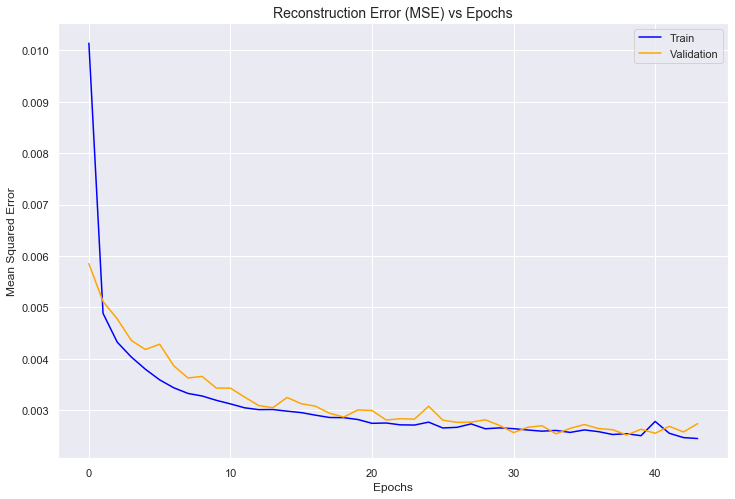

In [43]:
autoencoder.compile(optimizer = 'adam', loss = 'mse')

reconstruct_cont = autoencoder.fit(
    scaled_cont, # Data is input,
    scaled_cont, # and output: try to reconstruct accurately
    epochs = 100,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)],
    verbose = 0
)

plt.figure(figsize = (12, 8))
plt.plot(reconstruct_cont.history['loss'], c = 'blue', label = 'Train')
plt.plot(reconstruct_cont.history['val_loss'], c = 'orange', label = 'Validation')
plt.title('Reconstruction Error (MSE) vs Epochs', fontsize = 14)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()

Training of the autoencoder is stopped after $44$ epochs, as validation loss is no longer improving. After fitting is complete we extract the encoder, i.e. the first half of the neural network up to and including the narrow layer bottleneck, which maps raw inputs to their compressed representation. 

Using that sub-network to run predict on the raw minmax-scaled continuous data we get the compressed representation. The resulting matrix with five dimensions is saved to disk, so that we can cluster on it.

In [45]:
# Extract the encoder: maps raw inputs to their compressed representation
encoder = Model(inputs, encoder)

# Get compressed dataset of continuous numerical variables
auto = encoder.predict(scaled_cont)

# Save to disk
np.save('../data/final/encoded_cont_5wide', auto)

# Print dimensions for verification
auto.shape

(213675, 5)

### Autoencoder: hashed artists
For artist names a validation split of $10\%$ may seem low. However, we have 30,000 unique artist names across 200,000 observations, captured by 1,000 hashed features, so if the validation set is too large it will contain many observations that are the only observations of some artist hashes. This would reduce the overall effectiveness of the autoencoder at capturing as much of the salient information as possible in its compressed space. As such, we still use $10\%$ of the observations for validation, which still gives 20,000 observations and should be plenty to representatively evaluate out-of-sample performance.

After some experimentation the encoding layer now outputs $20$ dimensions rather than $5$, in order to strike a better balance between compression and accuracy in this much higher-dimensional input space (1,000 hashed artist names versus $17$ continuous variables).

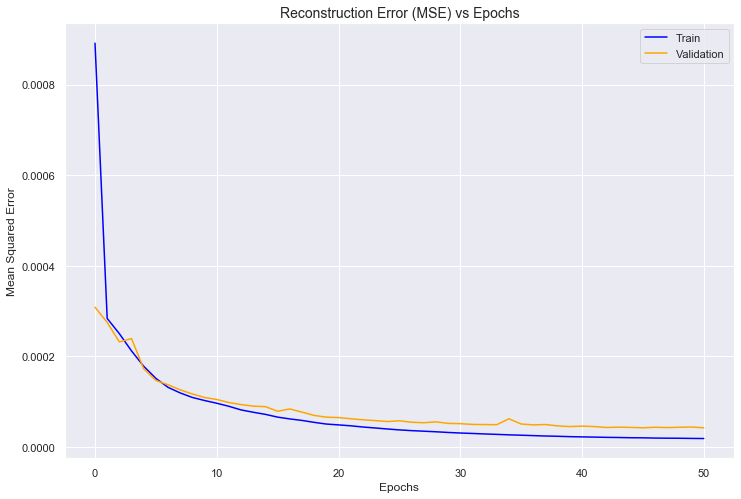

In [55]:
inputs = Input(shape = (scaled_artist.shape[1],))

encoder = Dense(500, activation = 'relu')(inputs)
encoder = Dense(500, activation = 'relu')(encoder)
encoder = Dense(20, activation = 'sigmoid')(encoder)
decoder = Dense(500, activation = 'relu')(encoder)
decoder = Dense(500, activation = 'relu')(decoder)
decoder = Dense(scaled_artist.shape[1])(decoder)

autoencoder = Model(inputs, decoder)

autoencoder.compile(optimizer = 'adam', loss = 'mse')

reconstruct_artist = autoencoder.fit(
    scaled_artist,
    scaled_artist,
    epochs = 100,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)],
    verbose = 0
)

plt.figure(figsize = (12, 8))
plt.plot(reconstruct_artist.history['loss'], c = 'blue', label = 'Train')
plt.plot(reconstruct_artist.history['val_loss'], c = 'orange', label = 'Validation')
plt.title('Reconstruction Error (MSE) vs Epochs', fontsize = 14)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()

As before early stopping is triggered, this time after 50 epochs. The loss is *very* low, but this is arguably more because there is a mean of one value $1$ across 1,000 dimensions per observation. The network has no context with which to encode artist hashes into a lower-dimensional space, and is working with extremely sparse data, so this is a virtually impossible task. Spot checks revealed that it was generally performing poorly at the task of reconstructing the normalised hashes, despite what the plot and training history would suggest. Hence, this autoencoder and its constituent encoder was discarded for the rest of the project.